In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

data_path = '/home/sam/Desktop/Monday_group/Monday_talk/data/'
df = pd.read_csv(data_path + 'train.csv')
# test_df = pd.read_csv(data_path + 'test.csv', index_col=0)

print df.shape
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [26]:
# drop 'Name', 'Ticket', 'Cabin' axis
df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

# convert strings to numberic values
## Embarked
for i in range(len(df)):
    index_i = df.index[i]
    embarked_i = df.loc[index_i, 'Embarked']
    if embarked_i == 'S':
        df.loc[index_i, 'Embarked'] = 0
    elif embarked_i == 'C':
        df.loc[index_i, 'Embarked'] = 1
    elif embarked_i == 'Q':
        df.loc[index_i, 'Embarked'] = 2
## Sex
le_sex = preprocessing.LabelEncoder()
le_sex.fit(df['Sex'])
df['Sex'] = le_sex.transform(df['Sex'])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,0,7.9250,0
3,1,1,0,35,1,0,53.1000,0
4,0,3,1,35,0,0,8.0500,0


#### Manually take out more values

In [27]:
train_df = pd.DataFrame.copy(df)

n_miss = 200
n_seed = 0
for i in range(n_miss):
    np.random.seed(n_seed)
    x_i = np.random.choice([1,2,4,5,6,7])
    np.random.seed(n_seed+1)
    y_i = np.random.randint(0, df.shape[0])
    train_df.iloc[y_i, x_i] = None
    n_seed += 5
# save it as train_missed.csv
train_df.to_csv('/home/sam/Desktop/Monday_group/Monday_talk/data/train_missed.csv', index=False)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,NaN,7.9250,0
3,1,1,0,35,1,0,NaN,0
4,0,3,1,35,0,0,8.0500,0


### Number of null values in train

In [28]:
# number of missing values in each attribute
print 'Number of columns that has missing value:', train_df.isnull().any(0).sum()
train_df.isnull().sum(axis=0)

Number of columns that has missing value: 7


Survived      0
Pclass       34
Sex          38
Age         177
SibSp        34
Parch        28
Fare         33
Embarked     35
dtype: int64

In [29]:
# number of missing value each row contains
print 'Total dim:', train_df.shape
print 'Number of rows that has missing value:', train_df.isnull().any(1).sum()
train_df.isnull().sum(axis=1).tail()

Total dim: (891, 8)
Number of rows that has missing value: 322


886    0
887    0
888    1
889    0
890    0
dtype: int64

### Build Model

#### define ROC plotting function

In [36]:
def plot_roc(pred, y):
    rcParams['figure.figsize'] = 5, 5
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# def maj_vote(kpred):
#     kpred_array = np.array(kpred)
#     return [pd.Series(i).value_counts().index[0] for i in kpred.T]


#### Define train function with stratified K-fold cross-validation

In [32]:
def train_cv(clf, train_data):
    train = train_data.drop('Survived', axis=1).values
    train_label = train_data['Survived'].values
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)
    
    print "Starts training..."
    for train_index, val_index in skf.split(train, train_label):
        X_train, X_val = train[train_index], train[val_index]
        y_train, y_val = train_label[train_index], train_label[val_index]
        rf = clf
        rf.fit(X_train, y_train)
        train_accuracy = rf.score(X_train, y_train)
        val_accuracy = rf.score(X_val, y_val)
        val_prediction = rf.predict(X_val)
        print "Train accuracy: {0}\t Validation accuracy: {1}".format(train_accuracy, val_accuracy)
    plot_roc(val_prediction, y_val)
    
    print "Done!"  

### train without imputation

In [ ]:
train_cv(RandomForestClassifier(random_state=42), train_df)

### train with listwise deletion

Data after listwise deletion (569, 8)
Starts training...
Train accuracy: 0.973626373626	 Validation accuracy: 0.780701754386
Train accuracy: 0.971428571429	 Validation accuracy: 0.798245614035
Train accuracy: 0.969230769231	 Validation accuracy: 0.833333333333
Train accuracy: 0.962637362637	 Validation accuracy: 0.771929824561
Train accuracy: 0.982456140351	 Validation accuracy: 0.716814159292


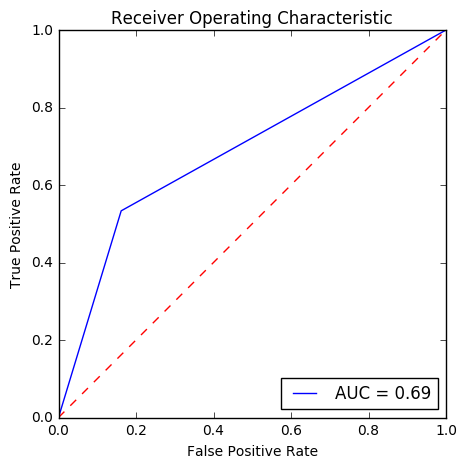

Done!


In [37]:
train1 = pd.DataFrame.copy(train_df)
# drop all rows that contain null value
train1.dropna(how='any', inplace=True)
print "Data after listwise deletion", train1.shape
train_cv(RandomForestClassifier(random_state=42), train1)

### train with imputation by mean/median/most_frequent

Starts training...
Train accuracy: 0.97191011236	 Validation accuracy: 0.765363128492
Train accuracy: 0.974719101124	 Validation accuracy: 0.793296089385
Train accuracy: 0.978962131837	 Validation accuracy: 0.808988764045
Train accuracy: 0.969144460028	 Validation accuracy: 0.85393258427
Train accuracy: 0.970588235294	 Validation accuracy: 0.774011299435


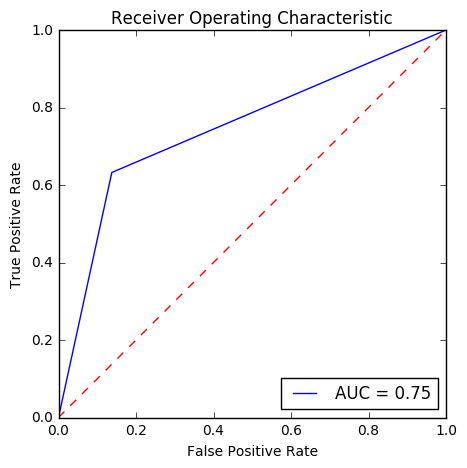

Done!


In [38]:
# mean, median, most_frequent
estimator = Pipeline([("imputer", Imputer(strategy="mean", axis=0)),
                      ("forest", RandomForestClassifier(random_state=42))])
train_cv(estimator, train_df)

### train with MICE(Multivariate Imputation by Chained Equations)

In [39]:
# obtain data transformed by MICE in R
mice_df = pd.read_csv(data_path + 'miced.csv')
mice_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,0,7.9250,0
3,1,1,0,35,1,0,153.4625,0
4,0,3,1,35,0,0,8.0500,0


Starts training...
Train accuracy: 0.97191011236	 Validation accuracy: 0.810055865922
Train accuracy: 0.976123595506	 Validation accuracy: 0.865921787709
Train accuracy: 0.980364656381	 Validation accuracy: 0.825842696629
Train accuracy: 0.969144460028	 Validation accuracy: 0.870786516854
Train accuracy: 0.967787114846	 Validation accuracy: 0.824858757062


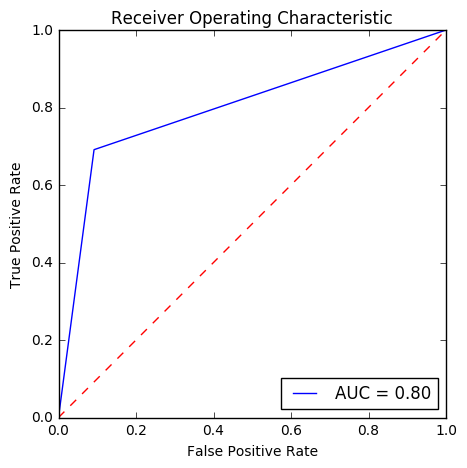

Done!


In [40]:
train_cv(RandomForestClassifier(random_state=42), mice_df)

### Note: always impute on validation set and training set sepeartly which we didn't do here